# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть», нужно решить, где бурить новую скважину.
Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модели для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.


**Цель:** постройка модели прогнозирования запасов сырья в скважине, анализ прибыли и рисков при помощи техники Bootstrap, рекомендация района для разработки.

**Задачи:**
1. Загрузка и подготовка данных.
2. Предобработка данных.
3. Поиск оптимальной модели.
4. Обучение и проверка моделей для каждого региона.
5. Поиск наилучшей модели.
6. Расчет прибыли, рисков, фактических средних и предсказанных средних запасов сырья.

**Предмет исследования** выборки данных для трех райнов.

**Методы:**
которые мы применим в данном исследовании включают в себя: ознакомление, предобработку, обучения моделей машинного обучения, графическая визуализация качества работы моделей, повышение метрик моделей, техника Bootstrap.

**Структура проекта:**
проектная работа состоит из обзора и предобработки данных, затем следует изучение точности различных моделей, поиск оптимальной модели, затем следует расчет прибыли и рисков и наконец общий вывод.

## Загрузка и подготовка данных

In [1]:
 # Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
 # чтение данных из выборок
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
 # Словарь содержащий выборки
region_dict = {'region 1': region_1,
               'region 2': region_2,
               'region 3': region_3}

Посмотрим на первые пять строк наших датасетов:

In [4]:
 for region in region_dict:
    
    print(region)
    display(region_dict[region].head())

region 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


region 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


region 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Оценим диапазоны значений:

In [5]:
for region in region_dict:
    
    print(region)
    display(region_dict[region].describe())

region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


region 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Диапазоны значений выглядят адекватно.

Проверим наши датасеты на дубликаты по столбцу id:

In [6]:
for region in region_dict:
    
    print(region)
    
    duplicated_id = region_dict[region]['id'].duplicated().sum()
    print(f'обнаружено {duplicated_id} дублированных строк по id:')
    
    display(pd.concat(g for _, g in region_dict[region].groupby('id') if len(g) > 1))

region 1
обнаружено 10 дублированных строк по id:


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


region 2
обнаружено 4 дублированных строк по id:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


region 3
обнаружено 4 дублированных строк по id:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В наших датасетах мы обнаружили некоторое значение дублированных строк по столбцу "id", следует уточнить у ответсвенного за выгрузку с чем это связанно, в любом случае какие строки с "id" удалить, а какие оставить неизвестно, оставляем как есть

Столбец "id" удалим из каждого датасета:

In [7]:
for region in region_dict:
    
    region_dict[region] = region_dict[region].drop('id', axis=1)
    
    display(region_dict[region].head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Оценим выбросы в данных:

region 1


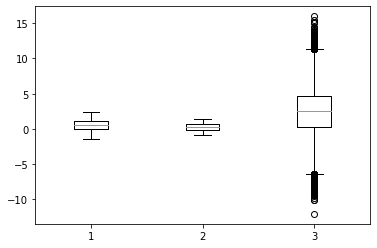

region 2


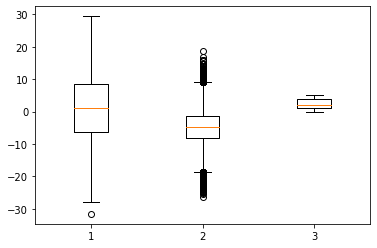

region 3


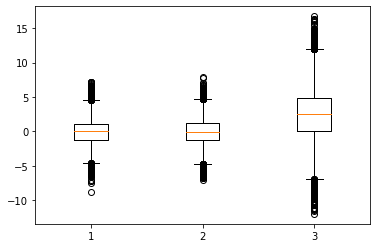

In [8]:
for region in region_dict:
    
    print(region)
    
    plt.boxplot(region_dict[region][['f0', 'f1', 'f2']]);
    plt.show()

Отфильтруем данные от выбросов:

In [9]:
def iqr_filtration(data):
    
    temp_dict = {}
    columns_list = ['f0', 'f1', 'f2']
    
    for region in data:
        
        temp_data = data[region]
        
        for column_name in columns_list:
            
            q1 = temp_data[column_name].quantile(0.25)
            q3 = temp_data[column_name].quantile(0.75)
            iqr = q3 - q1
            temp_data = temp_data[(temp_data[column_name] > q1 - 1.5 * iqr) 
                                  & (temp_data[column_name] < q3 + 1.5 * iqr)]
            
        temp_dict[region] = temp_data
        row_filtered = len(data[region]) - len(temp_data)
        
        print(f'В датасете {region} отфильтровано {row_filtered} строк')
        
    return temp_dict

In [10]:
region_iqr_list = iqr_filtration(region_dict)

В датасете region 1 отфильтровано 506 строк
В датасете region 2 отфильтровано 637 строк
В датасете region 3 отфильтровано 1997 строк


Проверим работу функции фильтрации:

Датасет region 1, диаграмма boxplot после фильтрации:


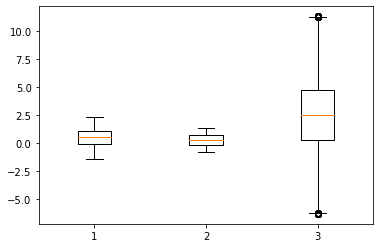

Датасет region 2, диаграмма boxplot после фильтрации:


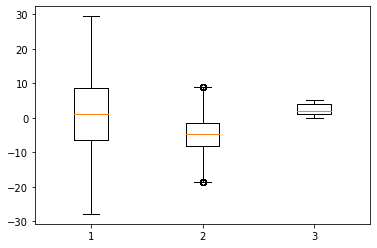

Датасет region 3, диаграмма boxplot после фильтрации:


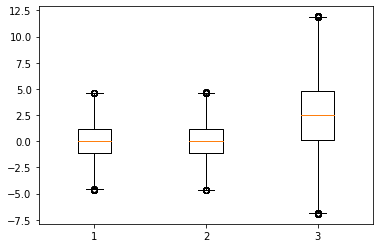

In [11]:
for region in region_iqr_list:
    
    print(f'Датасет {region}, диаграмма boxplot после фильтрации:')
    
    plt.boxplot(region_iqr_list[region][['f0', 'f1', 'f2']]);
    plt.show()

Данные очищены

Взглянем на распределение целевого признака в датасетах:

region 1


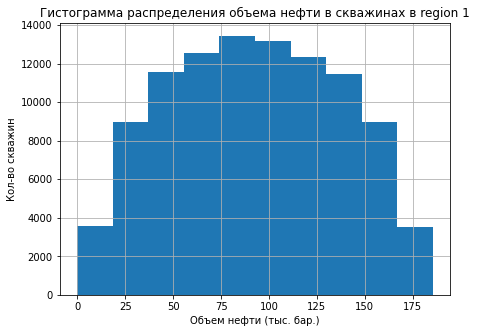

region 2


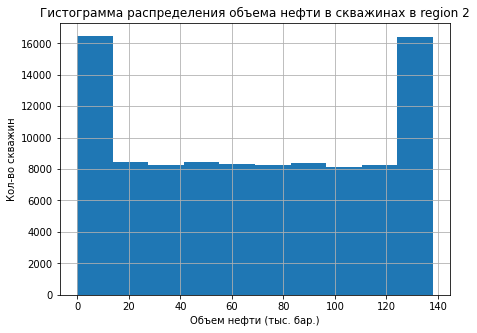

region 3


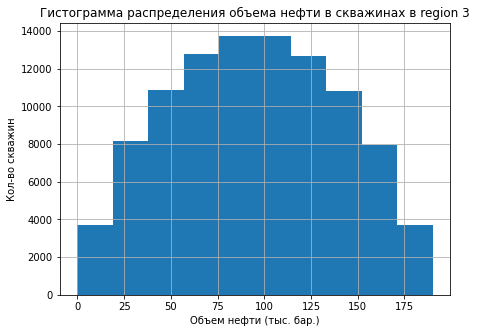

In [12]:
for region in region_iqr_list:
    
    print(region)
    
    region_iqr_list[region]['product'].hist(bins = 10, figsize=[7,5])
    
    plt.xlabel('Объем нефти (тыс. бар.)')
    plt.ylabel('Кол-во скважин')
    plt.title(f'Гистограмма распределения объема нефти в скважинах в {region}')
    plt.show()

В регионе 1 и 3 распределение целевого признака нормальное, в регионе 2 странное распределение.

Также обратим внимание на корреляцию признаков в датасетах:

Кореляционная матрица по region 1:


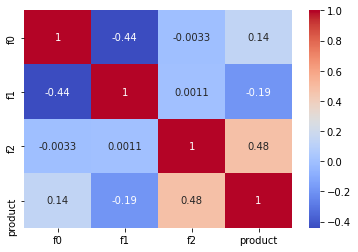

Кореляционная матрица по region 2:


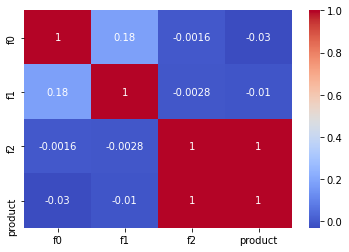

Кореляционная матрица по region 3:


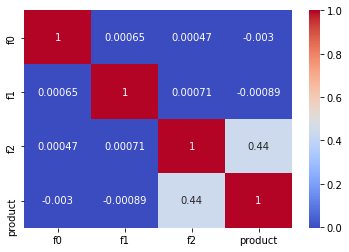

In [13]:
for region in region_iqr_list:
    
    print(f'Кореляционная матрица по {region}:')
    
    corr = region_iqr_list[region].corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot = True)
    plt.show()

Первый регион:

    f0 и f1 - отрицательно коррелируют друг с другом
    f2 и целевой признак - имеется корреляция 0.44

Второй регион:

    f2 и целевой признак - сильная корреляция
    f1 и целевой признак - слабая корреляция
    
Третий регион:

    f2 и целевой признак - сильная корреляция
    f1 и целевой признак - слабая корреляция
    f2 и целевой признак - имеется корреляция 0.44

## Обучение и проверка модели

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

In [14]:
scaler = StandardScaler()

# Функция разделения целевого показателя и признаком на тренировочные и валидационные выборки
def data_separation(data):
    
    target = data['product']
    features = data.drop(['product'], axis=1)
    
    features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                                target, 
                                                                                test_size=0.25, 
                                                                                random_state=12345)
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)

    return features_train, features_test, target_train, target_test

In [15]:
features_train_reg_1, features_test_reg_1, target_train_reg_1, target_test_reg_1 = data_separation(region_iqr_list['region 1'])
features_train_reg_2, features_test_reg_2, target_train_reg_2, target_test_reg_2 = data_separation(region_iqr_list['region 2'])
features_train_reg_3, features_test_reg_3, target_train_reg_3, target_test_reg_3 = data_separation(region_iqr_list['region 3'])

target = {}

target['region_1'] = target_test_reg_1
target['region_2'] = target_test_reg_2
target['region_3'] = target_test_reg_3

### Поиск наилучшей модели модели

In [16]:
    lr = LinearRegression()
    ridge = Ridge()
    lasso = Lasso()
    model_list = [lr, ridge, lasso]

In [17]:
 # Функция для построения результирующей таблицы результатов для разных моделей  
def statistic_table (region_list, model_list):
    
    table = pd.DataFrame()
    i = 0
    
    for key, value in region_list.items(): # обход словаря датасетов
        
        features_train, features_test, target_train, target_test = data_separation(value) # разделение данных
        
        for model in model_list: # обход списка моделей
            
             # обучение, предсказание 
            carrent_model = model
            model.fit(features_train, target_train) 
            predict = model.predict(features_test)
            
            # расчет метрик 
            rmse = np.sqrt(metrics.mean_squared_error(target_test, predict))
            mean_well_capacity_predict = predict.mean()
            mean_well_capacity_real =  target_test.mean()
            
             # заполнение таблицы
            table.loc[i, 'region'] = key
            table.loc[i, 'model'] = model
            table.loc[i, 'rmse'] = rmse
            table.loc[i, 'real_mean_capacity'] = mean_well_capacity_real
            table.loc[i, 'predict_mean_capacity'] = mean_well_capacity_predict
            
            i += 1
        
    return table   

In [18]:
statistic_table(region_iqr_list, model_list)

,region,model,rmse,real_mean_capacity,predict_mean_capacity
0,region 1,LinearRegression(),37.922931,92.237804,92.724768
1,region 1,Ridge(),37.922930,92.237804,92.724767
2,region 1,Lasso(),37.947700,92.237804,92.709311
3,region 2,LinearRegression(),0.889031,68.576334,68.571559
4,region 2,Ridge(),0.889032,68.576334,68.571564
5,region 2,Lasso(),1.676011,68.576334,68.576056
6,region 3,LinearRegression(),40.176797,94.798518,94.677169
7,region 3,Ridge(),40.176798,94.798518,94.677171
8,region 3,Lasso(),40.192911,94.798518,94.683617


По результатам тестирования указанных в таблице выше: все три модели показали одинаковый результат с незначительными отклонениями, мы будем в дальнейщем использовать LinearRegression()

### Обучите модель и сделайте предсказания на валидационной выборке.

#### Region 1

In [19]:
 # Функция визуализации работы модели
def model_visualization(target, y_pred):
    
     # компоновка, упорядочивание данных
    table = pd.concat([target.reset_index(drop=True), y_pred], axis=1 )
    table = (table.rename(columns={'product': 'target', 0: 'predict'})
                  .sort_values(by='target')
                  .reset_index(drop=True)
    )
    
     # выборка данных
    predict = table['predict'][0:len(table):1]
    target = table['target'][0:len(table):1]
    
     # градиентная окраска
    x = list(range(0, len(predict)))
    y = predict
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
     # построение диаграммы
    plt.figure(figsize=(10, 5), dpi=80)
    plt.scatter(list(range(0,len(predict))), predict, c=z, s=15)
    plt.scatter(list(range(0,len(predict))), target, alpha=0.1, color='red', s=10)

    plt.show()

In [20]:
prediction = {}


pipe = Pipeline(steps=[('lr', lr)])


 # Задаем решетку параметров пайплайна
param_grid = {'lr__copy_X': [True, False],
             'lr__fit_intercept': [True, False],
             'lr__normalize': [True, False],
             'lr__positive': [True, False]}

 # Создаем grid_search и передаем ему пайплайн, решетку параметров, также используем кросс-валидацию результата    
grid_search_cv_lr = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring="neg_mean_squared_error")

 # Обучаем модель на тренировочной части выборки:
grid_search_cv_lr.fit(features_train_reg_1, target_train_reg_1)

best_params_lr_region_1 = grid_search_cv_lr.best_params_ # Лучшие параметры
best_lr_region_1 = grid_search_cv_lr.best_estimator_ # Лучшая модель
best_lr_score_region_1 = grid_search_cv_lr.best_score_ # Лучший результат


prediction__region_1 = best_lr_region_1.predict(features_test_reg_1)
prediction['region_1'] = prediction__region_1
rmse = np.sqrt(metrics.mean_squared_error(target_test_reg_1, prediction__region_1))

print(f'Точность модели {lr} на тренировочной выборке составила: \
      {best_lr_score_region_1} с параметрами \
      {best_params_lr_region_1}')
print(f'RMSE: {rmse}')

Точность модели LinearRegression() на тренировочной выборке составила:       -1418.6565307547871 с параметрами       {'lr__copy_X': True, 'lr__fit_intercept': True, 'lr__normalize': True, 'lr__positive': False}
RMSE: 37.922930890531454


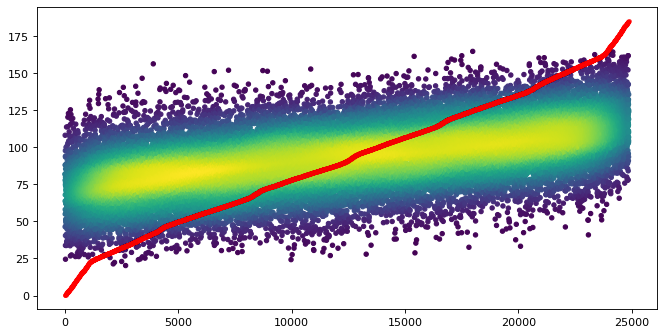

In [21]:
target_region_1 = pd.DataFrame(target_test_reg_1)
pred_region_1 = pd.DataFrame(prediction__region_1)
model_visualization(target_region_1, pred_region_1)

Модель для региона 1 имееет RMSE 38, судя по графику модель слабо передает целевой признак, только при значениях целевого признака 75 - 100 модель хорошо работает, а в остальном: при меньших показания целевого признакаа модель ошибается в большую сторону а при больших соответсвенно в меньшую. 

#### Region 2

In [22]:
 # Обучаем модель на тренировочной части выборки:
grid_search_cv_lr.fit(features_train_reg_2, target_train_reg_2)

best_params_lr_region_2 = grid_search_cv_lr.best_params_ # Лучшие параметры
best_lr_region_2 = grid_search_cv_lr.best_estimator_ # Лучшая модель
best_lr_score_region_2 = grid_search_cv_lr.best_score_ # Лучший результат

prediction__region_2 = best_lr_region_2.predict(features_test_reg_2)
prediction['region_2'] = prediction__region_2
rmse = np.sqrt(metrics.mean_squared_error(target_test_reg_2, prediction__region_2))

print(f'Точность модели {lr} на тренировочной выборке составила: \
      {best_lr_score_region_2} с параметрами \
      {best_params_lr_region_2}')
print(f'RMSE: {rmse}')

Точность модели LinearRegression() на тренировочной выборке составила:      -0.7942086542631314 с параметрами      {'lr__copy_X': True, 'lr__fit_intercept': True, 'lr__normalize': False, 'lr__positive': False}
RMSE: 0.8890307022067054


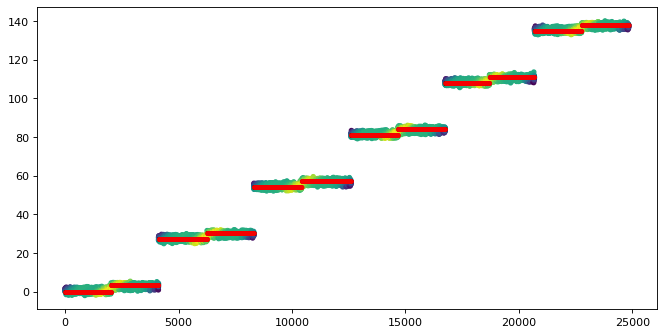

In [23]:
target_region_2 = pd.DataFrame(target_test_reg_2)
pred_region_2 = pd.DataFrame(prediction__region_2)
model_visualization(target_region_2, pred_region_2)

Во втором регионе распределение данных очень странное, данные больше похожи на синтетические - требуется консультация с ответсвенными за выгрузку данных, модель хорошо обучилась и довольно точно предсказывает результат.

#### Region 3

In [24]:
 # Обучаем модель на тренировочной части выборки:
grid_search_cv_lr.fit(features_train_reg_3, target_train_reg_3)

best_params_lr_region_3 = grid_search_cv_lr.best_params_ # Лучшие параметры
best_lr_region_3 = grid_search_cv_lr.best_estimator_ # Лучшая модель
best_lr_score_region_3 = grid_search_cv_lr.best_score_ # Лучший результат

prediction__region_3 = best_lr_region_3.predict(features_test_reg_3)
prediction['region_3'] = prediction__region_3
rmse = np.sqrt(metrics.mean_squared_error(target_test_reg_3, prediction__region_3))

print(f'Точность модели {lr} на тренировочной выборке составила: \
      {best_lr_score_region_3} с параметрами \
      {best_params_lr_region_3}')
print(f'RMSE: {rmse}')

Точность модели LinearRegression() на тренировочной выборке составила:      -1606.0949872791546 с параметрами      {'lr__copy_X': True, 'lr__fit_intercept': True, 'lr__normalize': False, 'lr__positive': True}
RMSE: 40.17695046244152


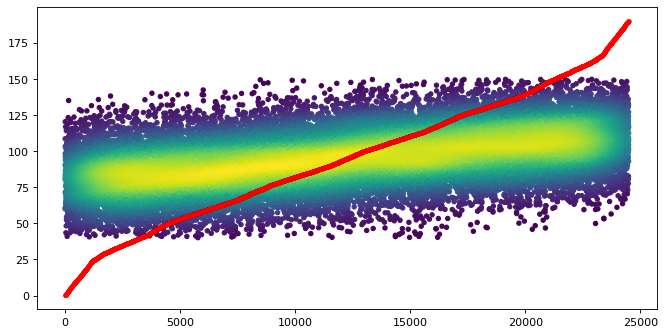

In [25]:
target_region_3 = pd.DataFrame(target_test_reg_3)
pred_region_3 = pd.DataFrame(prediction__region_3)
model_visualization(target_region_3, pred_region_3)

RMSE модели составило 40, модель ведет себя также как и модель первого региона.

### Напечатайте на экране средний запас предсказанного сырья и RMSE модели

In [26]:
pivot_table = pd.DataFrame()
i = 1   

for key, value in prediction.items():
    pivot_table.loc[i, 'model'] = lr
    pivot_table.loc[i, 'region'] = 'Region_' + str(i)
    pivot_table.loc[i, 'mean_predict_capacity'] = value.mean()
    pivot_table.loc[i, 'mean_real_capacity'] = target[key].mean() 
    pivot_table.loc[i, 'rmse'] = np.sqrt(metrics.mean_squared_error(target[key], value))
    i += 1

In [27]:
pivot_table

,model,region,mean_predict_capacity,mean_real_capacity,rmse
1,LinearRegression(),Region_1,92.724768,92.237804,37.922931
2,LinearRegression(),Region_2,68.571559,68.576334,0.889031
3,LinearRegression(),Region_3,94.678414,94.798518,40.176950


### Проанализируйте результаты

## Подготовка к расчёту прибыли

In [28]:
param_dict = {'well_qnt': 500,
              'top_well_qnt': 200,
              'budget': 10**10,
              'income_barrel': 450,
              'loss_probability': 0.025}

In [29]:
sufficient_volume_region = round(param_dict['budget'] / param_dict['top_well_qnt'] / (param_dict['income_barrel'] * 10**3), 3)

print(f'Средний запас сырья в скважине, для безубыточной разработки в регионе составляет {sufficient_volume_region} тыс. баррелей')

Средний запас сырья в скважине, для безубыточной разработки в регионе составляет 111.111 тыс. баррелей


## Расчёт прибыли и рисков 

In [30]:
def profit_calculation(target, prediction, top_well_qnt, budget, income_barrel):
    
    prediction_sort = prediction.sort_values(ascending=False)
    top = target[prediction_sort.index][:top_well_qnt]
    revenue = income_barrel * 10**3 * top.sum()
    profit = revenue - budget
    return profit

In [31]:
def region_analysis(target, predictions, param, region_name):
    
    values = []
    state = np.random.RandomState(12345)
    
    for key, value in param.items():
        
        if key == 'well_qnt':
            well_qnt = value
        elif key == 'top_well_qnt':
            top_well_qnt = value
        elif key == 'budget':
            budget = value
        elif key == 'income_barrel':
            income_barrel = value
        elif key == 'loss_probability':
            loss_probability = value
            
    for i in range(1000):
        target_subsample = (target.reset_index(drop=True)
                                 .sample(n=well_qnt, 
                                         replace=False, 
                                         random_state=state)
        )
        pred_subsample = predictions[target_subsample.index]
        value = profit_calculation(target_subsample, pred_subsample, top_well_qnt, budget, income_barrel)
        values.append(value)
        
    values = pd.Series(values)
    risk = (values < 0).mean()
        
    lower = values.quantile(loss_probability)
    upper = values.quantile(1 - loss_probability)
        
    print(f'Средняя прибыль в {region_name}: {round(values.mean(), 2)} млн. руб')
    print(f'95% доверительный интервал: ({lower}, {upper})')
    print(f'Риск убытков: {risk * 100}')
        
    if risk <= loss_probability:
        print('Риск убытков меньше необходимого значения. Регион можно оставить.')
    else:
        print('Риск убытков больше необходимого значения.')
    print( )

In [32]:
def common_analysis(region_dict, param):
    for key, value in region_dict.items():
        target = value['product']
        features = value.drop(['product'], axis=1)
        features = scaler.fit_transform(features)
        features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)
        pipe = Pipeline(steps=[('lr', lr)]) # Создаем пайплайн

        # Задаем решетку параметров пайплайна
        param_grid = {'lr__copy_X':[True, False],
             'lr__fit_intercept':[True, False],
             'lr__normalize':[True, False],
             'lr__positive':[True, False]}

        # Создаем нашу модель и передаем ей пайплайн, решетку параметров, также используем кросс-валидацию результата    
        grid_search_cv_lr = GridSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring="neg_mean_squared_error")

        # Обучаем модель на тренировочной части выборки:
        grid_search_cv_lr.fit(features_train, target_train)
        best_lr = grid_search_cv_lr.best_estimator_ # Лучшая модель
        predictions = pd.Series(best_lr.predict(features_test))
        region_analysis(pd.Series(target_test), predictions, param, key)
        

In [33]:
common_analysis(region_iqr_list, param_dict)

Средняя прибыль в region 1: 369846681.96 млн. руб
95% доверительный интервал: (-155696070.04446873, 908556013.2387173)
Риск убытков: 7.7
Риск убытков больше необходимого значения.

Средняя прибыль в region 2: 438002489.19 млн. руб
95% доверительный интервал: (28194534.490594104, 827952214.1503843)
Риск убытков: 1.6
Риск убытков меньше необходимого значения. Регион можно оставить.

Средняя прибыль в region 3: 358450010.6 млн. руб
95% доверительный интервал: (-177744011.27741998, 854312520.3199828)
Риск убытков: 8.200000000000001
Риск убытков больше необходимого значения.



## Общий вывод

Мы ознакомились и предобработали данные, иизбавились от выбросов в значениях, разбили данные на тренировочные и валидационные выборки, определили и обучили модель линейной регрессии для каждого региона.
 
При анализе - обратили внимание на странное распределение данных во втором регионе.

Рассчитали среднее содержание сырья для безубыточной добычи в регионе.

При помощи методики Bootstrap нашли распределение прибыли.

Для разработки подходит регион номер 2 с метриками:

    Средняя прибыль: 438002489.19 млн. руб
    95% доверительный интервал: (28194534.490594104, 827952214.1503843)
    Риск убытков: 1.6